<a href="https://colab.research.google.com/github/VikaBilyk/mss/blob/main/lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

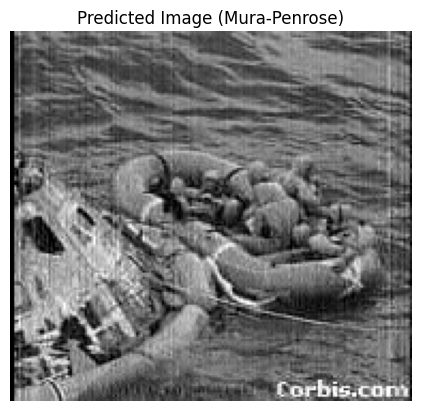

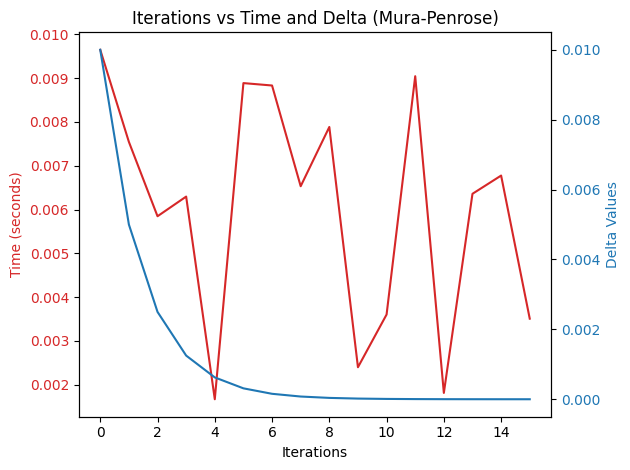

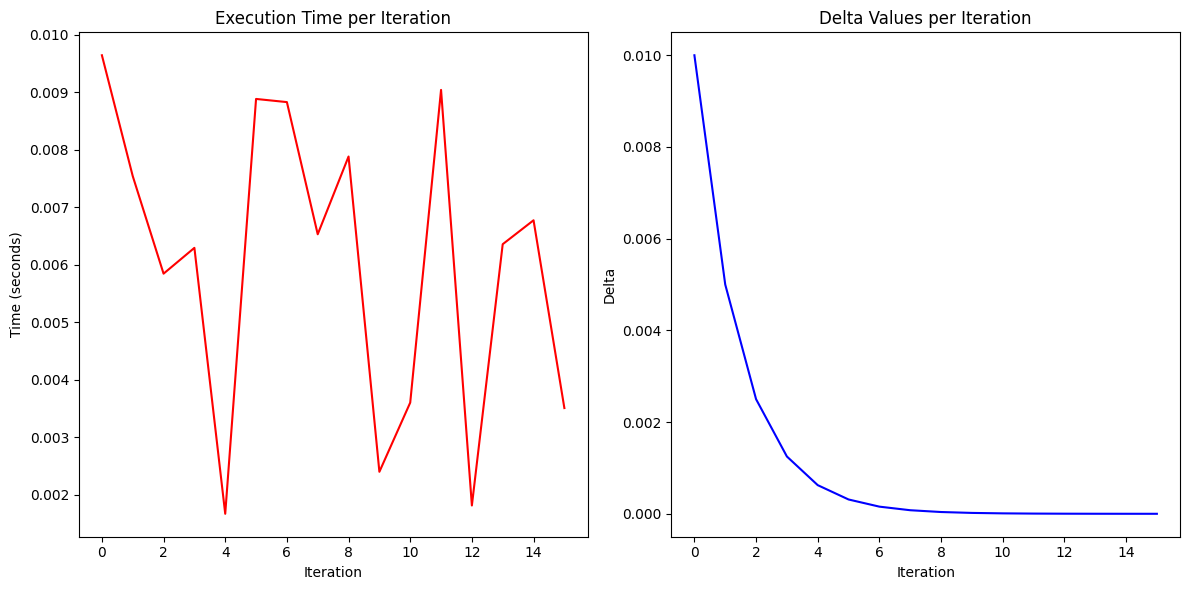


--- Efficiency Information for Mura-Penrose ---
Total Iterations: 16
Delta Value at Last Iteration: 3.0517578125e-07
Total Time: 0.09663 seconds
Condition AA+A = A: Satisfied
Condition A+AA+ = A+: Satisfied
Condition AA+ is symmetric: Satisfied
Condition A+A is symmetric: Satisfied


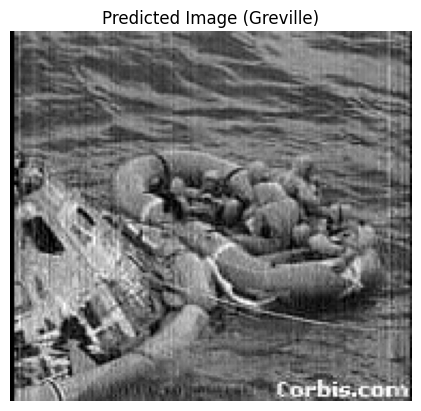

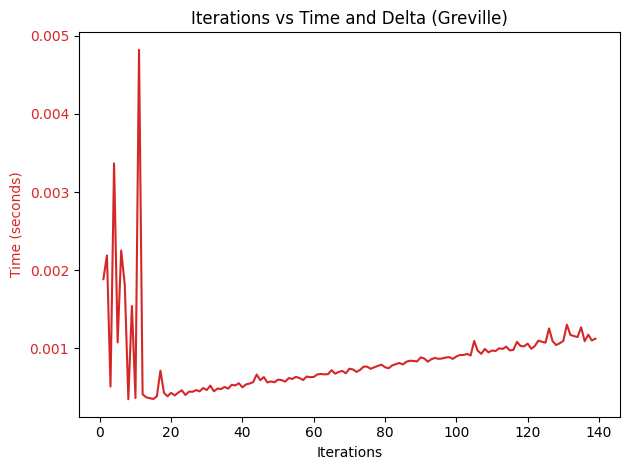

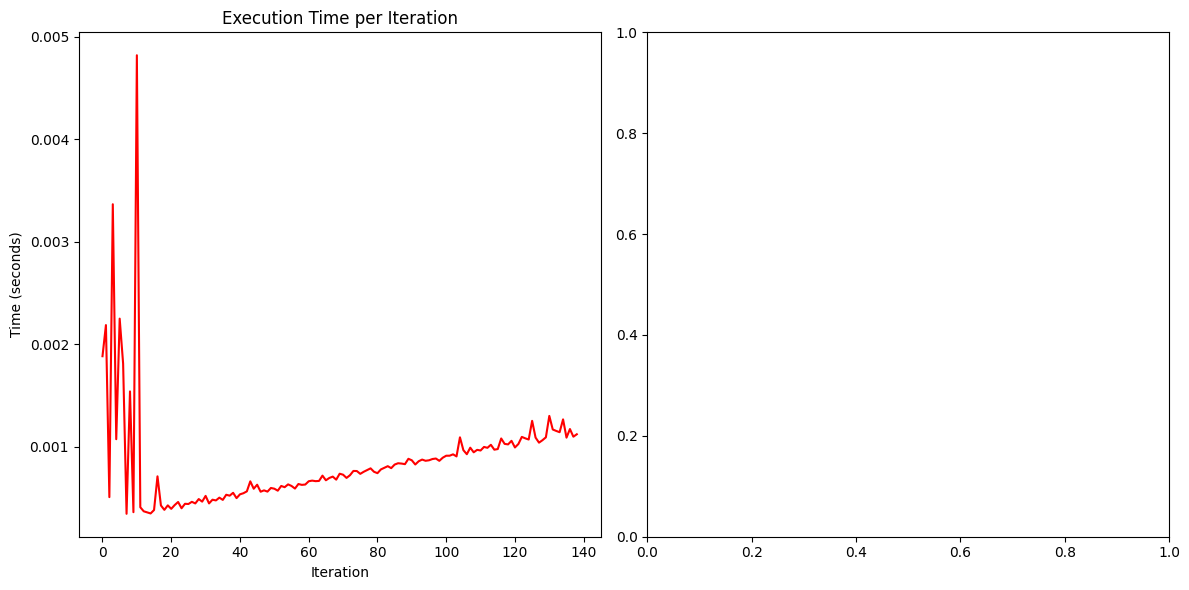


--- Efficiency Information for Greville ---
Total Iterations: 139
Total Time: 0.11757 seconds
Condition AA+A = A: Satisfied
Condition A+AA+ = A+: Satisfied
Condition AA+ is symmetric: Satisfied
Condition A+A is symmetric: Satisfied


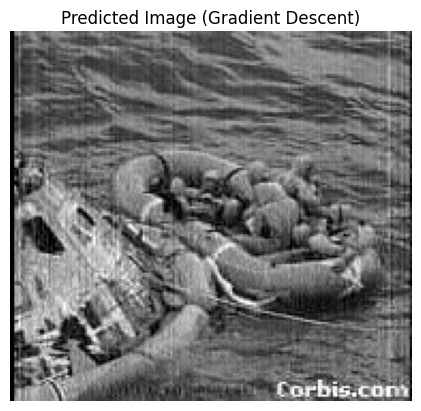

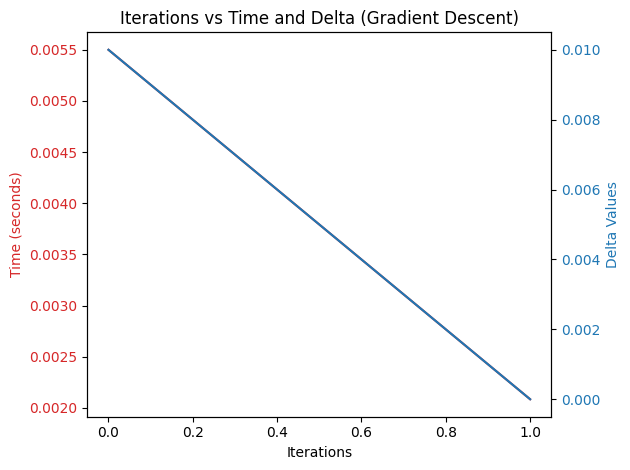

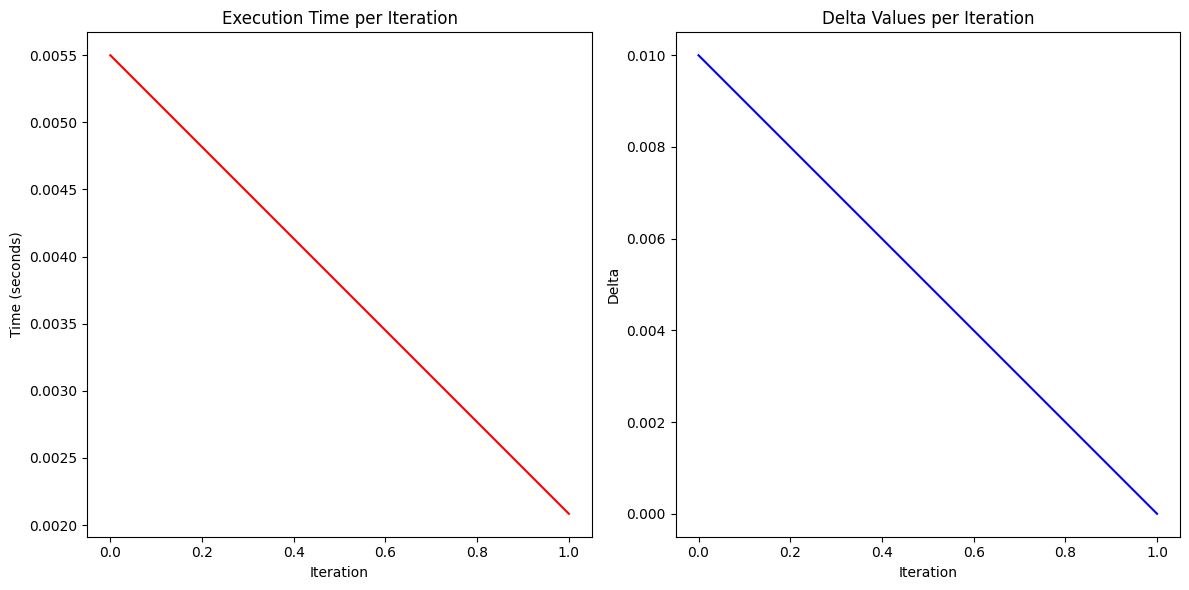


--- Efficiency Information for Gradient Descent ---
Total Iterations: 2
Delta Value at Last Iteration: 1e-06
Total Time: 0.00758 seconds
Condition AA+A = A: Satisfied
Condition A+AA+ = A+: Not satisfied
Condition AA+ is symmetric: Satisfied
Condition A+A is symmetric: Satisfied


In [106]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import time

def compute_pseudo_inverse(matrix, delta_initial, epsilon=1e-5, max_iterations=1000):
    identity_matrix = np.eye(matrix.shape[0])
    delta_current = delta_initial
    exec_times, delta_log, iteration_log = [], [], []

    for iteration in range(max_iterations):
        start_time = time.time()

        pseudo_inv = matrix.T @ np.linalg.inv(matrix @ matrix.T + delta_current**2 * identity_matrix)
        delta_new = delta_current / 2

        exec_times.append(time.time() - start_time)
        delta_log.append(delta_current)
        iteration_log.append(iteration)

        if np.linalg.norm(pseudo_inv - matrix.T @ np.linalg.inv(matrix @ matrix.T + delta_new**2 * identity_matrix)) < epsilon:
            break

        delta_current = delta_new

    return pseudo_inv, iteration_log, exec_times, delta_log

def greville_method(matrix, delta, eps=1e-5):
    first_row = matrix[0].reshape(-1, 1)  # Ensure first_row is a column vector
    first_row = matrix[0]
    denominator = np.dot(first_row.T, first_row)
    pseudo_inverse = np.vstack(first_row / denominator if denominator != 0 else first_row)

    current_matrix = np.array([first_row])
    num_rows = matrix.shape[0]

    iteration_times = []  # Час на кожну ітерацію Греввіля
    iteration_counts = []  # Номер ітерації Греввіля

    for i in range(1, num_rows):
        start_time = time.time()  # Початок відліку часу для кожної ітерації

        current_row = matrix[i].reshape(-1, 1)
        identity_matrix = np.identity(current_matrix.shape[1])
        projection_matrix = identity_matrix - np.dot(pseudo_inverse, current_matrix)


        current_matrix = np.vstack([current_matrix, matrix[i]])
        denominator = np.dot(current_row.T, np.dot(projection_matrix, current_row))[0, 0]

        if np.abs(denominator) < eps:
            correction_matrix = np.dot(pseudo_inverse, pseudo_inverse.T)
            denominator = 1 + np.dot(current_row.T, np.dot(correction_matrix, current_row))
            pseudo_inverse = np.hstack([
                pseudo_inverse - np.dot(projection_matrix, np.dot(current_row, np.dot(current_row.T, pseudo_inverse))) / denominator,
                np.dot(correction_matrix, current_row) / denominator
            ])
        else:
            pseudo_inverse = np.hstack([
                pseudo_inverse - np.dot(projection_matrix, np.dot(current_row, np.dot(current_row.T, pseudo_inverse))) / denominator,
                np.dot(projection_matrix, current_row) / denominator
            ])

        iteration_times.append(time.time() - start_time)
        iteration_counts.append(i)

    return pseudo_inverse, iteration_counts, iteration_times

def normalize(matrix):
    return (matrix - np.min(matrix)) / (np.max(matrix) - np.min(matrix))

def display_image(matrix, title):
    normalized_image = np.clip(matrix * 255, 0, 255).astype(np.uint8)
    img = Image.fromarray(normalized_image)
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

def plot_iterations_and_time(iteration_indices, exec_times, delta_values=None, method_name="Method"):
    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Time (seconds)', color='tab:red')
    ax1.plot(iteration_indices, exec_times, color='tab:red', label="Execution Time")
    ax1.tick_params(axis='y', labelcolor='tab:red')

    if delta_values is not None:
        ax2 = ax1.twinx()
        ax2.set_ylabel('Delta Values', color='tab:blue')
        ax2.plot(iteration_indices, delta_values, color='tab:blue', label="Delta Values")
        ax2.tick_params(axis='y', labelcolor='tab:blue')

    plt.title(f'Iterations vs Time and Delta ({method_name})')
    fig.tight_layout()
    plt.show()

def summarize_performance(exec_times, delta_values):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].plot(range(len(exec_times)), exec_times, color='red')
    axes[0].set_title('Execution Time per Iteration')
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel('Time (seconds)')

    if delta_values:
        axes[1].plot(range(len(delta_values)), delta_values, color='blue')
        axes[1].set_title('Delta Values per Iteration')
        axes[1].set_xlabel('Iteration')
        axes[1].set_ylabel('Delta')

    plt.tight_layout()
    plt.show()

def display_efficiency(iteration_indices, exec_times, delta_values=None, method_name="Method"):
    print(f"\n--- Efficiency Information for {method_name} ---")
    print(f"Total Iterations: {len(iteration_indices)}")
    if delta_values:
        print(f"Delta Value at Last Iteration: {delta_values[-1]}")
    print(f"Total Time: {sum(exec_times):.5f} seconds")

def verify_pseudo_inverse_properties(A, A_pseudo):
    conditions = [
        (np.allclose(A @ A_pseudo @ A, A), "Condition AA+A = A"),
        (np.allclose(A_pseudo @ A @ A_pseudo, A_pseudo), "Condition A+AA+ = A+"),
        (np.allclose(A @ A_pseudo, (A @ A_pseudo).T), "Condition AA+ is symmetric"),
        (np.allclose(A_pseudo @ A, (A_pseudo @ A).T), "Condition A+A is symmetric")
    ]

    for condition, description in conditions:
        print(f"{description}: {'Satisfied' if condition else 'Not satisfied'}")

    return [condition for condition, _ in conditions]

def gradient_descent_method(matrix, delta_initial, learning_rate_initial=0.001, epsilon=1e-5, max_iterations=1000, min_delta=1e-6):
    E_m = np.eye(matrix.shape[0])
    delta_current = delta_initial
    learning_rate = learning_rate_initial
    iteration_times, delta_log, iteration_indices = [], [], []

    for iteration in range(max_iterations):
        start_time = time.time()
        pseudo_inv_k = matrix.T @ np.linalg.inv(matrix @ matrix.T + delta_current**2 * E_m)
        gradient = 2 * delta_current * np.trace(np.dot(pseudo_inv_k.T, pseudo_inv_k))

        learning_rate = learning_rate_initial / (1 + 0.01 * iteration)
        new_delta = delta_current - learning_rate * gradient
        new_delta = max(new_delta, min_delta)

        iteration_times.append(time.time() - start_time)
        delta_log.append(delta_current)
        iteration_indices.append(iteration)

        if abs(new_delta - delta_current) < epsilon:
            break

        delta_current = new_delta

    return pseudo_inv_k, iteration_indices, iteration_times, delta_log

def main_process():
    # Load images
    image_input = Image.open("x1.bmp")
    image_output = Image.open("y2.bmp")

    # Convert images to matrices and normalize
    input_matrix = normalize(np.array(image_input, dtype=float))
    output_matrix = normalize(np.array(image_output, dtype=float))

    # Mura-Penrose Method
    pseudo_inv_mura, iter_counts, iter_times, delta_vals = compute_pseudo_inverse(input_matrix, 0.01)
    A_mura = output_matrix @ pseudo_inv_mura
    predicted_mura = A_mura @ input_matrix
    display_image(predicted_mura, title='Predicted Image (Mura-Penrose)')

    plot_iterations_and_time(iter_counts, iter_times, delta_vals, "Mura-Penrose")
    summarize_performance(iter_times, delta_vals)
    display_efficiency(iter_counts, iter_times, delta_vals, "Mura-Penrose")
    verify_pseudo_inverse_properties(input_matrix, pseudo_inv_mura)

    # Greville Method
    pseudo_inv_greville, iter_greville, iter_times_greville = greville_method(input_matrix, 0.01)
    A_greville = output_matrix @ pseudo_inv_greville
    predicted_greville = A_greville @ input_matrix
    display_image(predicted_greville, title='Predicted Image (Greville)')

    plot_iterations_and_time(iter_greville, iter_times_greville, method_name="Greville")
    summarize_performance(iter_times_greville, [])
    display_efficiency(iter_greville, iter_times_greville, method_name="Greville")
    verify_pseudo_inverse_properties(input_matrix, pseudo_inv_greville)

    # Gradient Descent Method
    pseudo_inv_gradient, iter_grad, iter_times_grad, delta_vals_grad = gradient_descent_method(input_matrix, 0.01)
    A_gradient = output_matrix @ pseudo_inv_gradient
    predicted_gradient = A_gradient @ input_matrix
    display_image(predicted_gradient, title='Predicted Image (Gradient Descent)')

    plot_iterations_and_time(iter_grad, iter_times_grad, delta_vals_grad, "Gradient Descent")
    summarize_performance(iter_times_grad, delta_vals_grad)
    display_efficiency(iter_grad, iter_times_grad, delta_vals_grad, "Gradient Descent")
    verify_pseudo_inverse_properties(input_matrix, pseudo_inv_gradient)

if __name__ == "__main__":
    main_process()
